<a href="https://colab.research.google.com/github/diya0603/Image-Captioning-Project/blob/main/Image_Captioning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Makes use of
- VGG16
- LSTM

#Import Modules

In [ ]:
import os
import pickle # for storing image features
import numpy as np
from tqdm.notebook import tqdm #ui for estimation of overall process

from tensorflow.keras.applications.vgg16 import VGG16, preprocess_input # for img feature extraction
from tensorflow.keras.preprocessing.image import load_img,img_to_array
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences #to make all captions the same length
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.layers import Input,Dense,LSTM,Embedding, Dropout ,add

In [ ]:
! pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
! mkdir ~/.kaggle

In [ ]:
! cp kaggle.json ~/.kaggle/

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

In [ ]:
! kaggle datasets download -d adityajn105/flickr8k

100% 1.03G/1.04G [00:38<00:00, 29.1MB/s]
100% 1.04G/1.04G [00:38<00:00, 28.9MB/s]


In [ ]:
! unzip flickr8k.zip

In [ ]:
BASE_DIR='/content/'
WORKING_DIR='/content/'

#Extract Image features

In [ ]:
#load vgg16 model
model=VGG16()

#restructure the model
model=Model(inputs=model.inputs, outputs=model.layers[-2].output) # we don't need the last two layers for feature extraction

#summarize
print(model.summary())

553467096/553467096 [==============================] - 15s 0us/step
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     147584    
                                                           

In [ ]:
#extract features from image #vocalbulary
features={} #dict with key-value pair [image-id: features]
directory=os.path.join(BASE_DIR,'Images')

for img_name in tqdm(os.listdir(directory)):
  #load the image from file
  img_path=directory + '/' + img_name #to get whole imagepath
  image=load_img(img_path,target_size=(224,224))
  #convert image pixels to numpy array
  image=img_to_array(image)
  #reshape data for model
  image=image.reshape((1,image.shape[0],image.shape[1],image.shape[2]))
  #preprocess image for vgg
  image=preprocess_input(image)
  #extract features
  feature=model.predict(image,verbose=0) #it won't display additional features
  #get image ID
  image_id=img_name.split('.')[0]
  #store feature
  features[image_id]=feature

  0%|          | 0/8091 [00:00<?, ?it/s]

In [ ]:
# store features in pickle
pickle.dump(features,open(os.path.join(WORKING_DIR, 'features.pkl'),'wb'))

In [ ]:
#load features from pickle
with open(os.path.join(WORKING_DIR,'features.pkl'),'rb') as f:
  features=pickle.load(f)

#Load the Captions Data

In [ ]:
with open(os.path.join(BASE_DIR,'captions.txt'),'r') as f:
  next(f) # we don't need the first line of file
  captions_doc=f.read()


In [ ]:
#for each img_id the coresponding caption
# create  mapping image to caption
mapping={}
# process lines
for line in tqdm(captions_doc.split('\n')):
  #split the line by comma(,)
  tokens=line.split(',')
  if len(line) < 2:
    continue #to avoid errors where there are lines with just one letter
  image_id, caption = tokens[0], tokens[1:]
  #remove extension from image ID
  image_id = image_id.split('.')[0]
  #convert caption list into string
  caption= " ".join(caption)
  #create list if needed
  if image_id not in mapping:
    mapping[image_id]=[]
  #store the caption
  mapping[image_id].append(caption)

  0%|          | 0/40456 [00:00<?, ?it/s]

In [ ]:
len(mapping)

8091

#Preprocess Text Data

In [ ]:
#to preprocess captions
def clean(mapping):
  for key,captions in mapping.items():
    for i in range(len(captions)):
      #take one caption at a time
      caption=captions[i]
      #preporcessing steps
      caption=caption.lower() #convert to lower case
      caption=caption.replace('[^A-Za-z]','') #delete digits, special chars,etc
      caption=caption.replace('\s+',' ') # for multiple spaces
      caption='starseq ' + " ".join([word for word in caption.split() if len(word)>1]) + ' endseq' #add start and end tags to the caption
      captions[i]=caption

In [ ]:
#before preprocess of text
mapping['1000268201_693b08cb0e']

['A child in a pink dress is climbing up a set of stairs in an entry way .',
 'A girl going into a wooden building .',
 'A little girl climbing into a wooden playhouse .',
 'A little girl climbing the stairs to her playhouse .',
 'A little girl in a pink dress going into a wooden cabin .']

In [ ]:
#preprocess the text
clean(mapping)

In [ ]:
#after preprocess of text
mapping['1000268201_693b08cb0e']

['starseq child in pink dress is climbing up set of stairs in an entry way endseq',
 'starseq girl going into wooden building endseq',
 'starseq little girl climbing into wooden playhouse endseq',
 'starseq little girl climbing the stairs to her playhouse endseq',
 'starseq little girl in pink dress going into wooden cabin endseq']

In [ ]:
all_captions = []
for key in mapping:
  for caption in mapping[key]:
    all_captions.append(caption)

In [ ]:
len(all_captions)

40455

In [ ]:
all_captions[:10]

In [ ]:
#tokenize the text to get indices of words
tokenizer=Tokenizer()
tokenizer.fit_on_texts(all_captions)
vocab_size=len(tokenizer.word_index) + 1 # word_index = unique words

In [ ]:
vocab_size

8485

In [ ]:
#get maximum length of the caption available (for padding,etc)
max_length = max(len(caption.split()) for caption in all_captions)
max_length

35

# Train Test Split

In [ ]:
image_ids=list(mapping.keys())
split = int(len(image_ids) * 0.90)
train = image_ids[:split]
test=image_ids[split:]

In [ ]:
# create a data generator to fetch data in batchs to avoid crashing the session
def data_generator(data_keys,mapping,features, tokenizer,max_length,vocab_size,batch_size):
  # loop over images
  X1,X2,y=list(),list(),list()
  n=0 # to determine if we reached the batch size
  while 1:     #infinite loop
    for key in data_keys: #img_ids of the train set
      n+=1
      captions=mapping[key]
      #process each caption
      for caption in captions:
        #encode the sequence
        seq=tokenizer.texts_to_sequences([caption])[0] #each word is assigned an index
        #split the sequence into X,y pairs
        for i in range(1,len(seq)):
          #split into in and out pairs
          in_seq, out_seq= seq[:i], seq[i]
          #pad in seq
          in_seq=pad_sequences([in_seq],maxlen=max_length)[0]
          #encode out seq
          out_seq = to_categorical([out_seq],num_classes=vocab_size)[0] #one-hot encoding

          #store the sequences
          X1.append(features[key][0]) #img features
          X2.append(in_seq) # text features
          y.append(out_seq)
      if n== batch_size:
        X1,X2,y=np.array(X1),np.array(X2),np.array(y)
        yield [X1,X2], y
        X1,X2,y=list(),list(),list()
        n=0

#Model Creation

In [ ]:
#encoder model
#image feature layers
inputs1=Input(shape=(4096,))
fe1=Dropout(0.4)(inputs1)
fe2=Dense(256,activation='relu')(fe1)
#sequence feature layers
inputs2=Input(shape=(max_length,))
se1=Embedding(vocab_size,256,mask_zero=True) (inputs2)#dim of input - vocab size
se2=Dropout(0.4)(se1)
se3=LSTM(256)(se2)

#decoder model
decoder1=add([fe2,se3])
decoder2=Dense(256,activation='relu')(decoder1)
outputs=Dense(vocab_size,activation='softmax')(decoder2)

model=Model(inputs=[inputs1,inputs2],outputs=outputs)

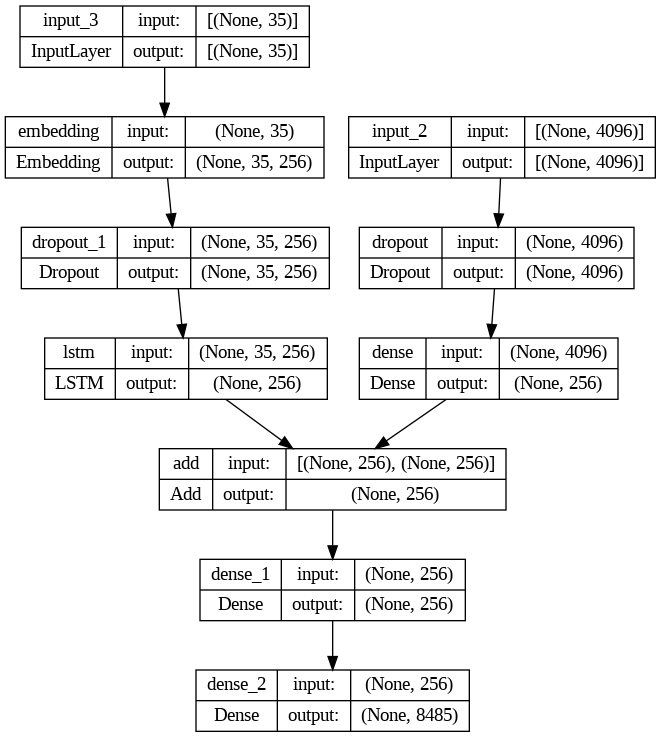

In [ ]:
model.compile(loss='categorical_crossentropy',optimizer='adam')

#plot the model
plot_model(model, show_shapes=True)

In [ ]:
#train the model
epochs=20
batch_size = 32
steps=len(train)// batch_size

for i in range(epochs):
  #create data generator
  generator= data_generator(train,mapping,features,tokenizer,max_length, vocab_size,batch_size)
  #fit for one epoch
  model.fit(generator, epochs=1,steps_per_epoch=steps,verbose=1)

227/227 [==============================] - 63s 276ms/step - loss: 2.1848


In [ ]:
model.save('img_model123.h5') #save the model

In [ ]:
from tensorflow import keras

In [ ]:
model=keras.models.load_model('img_model.h5')

#Generate the Captions for the Image

In [ ]:
# convert id from index to word
def idx_to_word(integer, tokenizer):
  for word, index in tokenizer.word_index.items():
    if index == integer:
      return word
  return None

In [ ]:
#generate caption for image
def predict_caption(model,image,tokenizer,max_length):
  in_text='startseq' #add start tag for generation process
  #iterate over the max length of sequence
  for i in range(max_length):
    #encode in seq
    sequence=tokenizer.texts_to_sequences([in_text])[0]
    #pad the seq
    sequence=pad_sequences([sequence],max_length)
    #predict next word
    yhat=model.predict([image,sequence],verbose=0)
    #get index with the highest probab
    yhat=np.argmax(yhat)
    #convert index to word
    word=idx_to_word(yhat,tokenizer)
    #stop if word not found
    if word is None:
      break
    #append as in for generation of next word
    in_text+= " " + word
    #stop if we reach end tag
    if word == 'endseq':
      break
  return in_text


In [ ]:
from nltk.translate.bleu_score import corpus_bleu
#validate with test data
actual,predicted=list(),list()

for key in tqdm(test):
  #get actual captions
  captions=mapping[key]
  #predict the caption for image
  y_pred=predict_caption(model,features[key],tokenizer,max_length)
  #split to words
  actual_captions=[caption.split() for caption in captions] # list of words in caption
  y_pred=y_pred.split()
  #append to the list
  actual.append(actual_captions)
  predicted.append(y_pred)

#calculate BLEU score
print('BLEU-1: %f' % corpus_bleu(actual,predicted,weights=(1.0,0,0,0)))
print('BLEU-2: %f' % corpus_bleu(actual,predicted,weights=(0.5,0.5,0,0)))

  0%|          | 0/810 [00:00<?, ?it/s]

BLEU-1: 0.378131
BLEU-2: 0.203873


#Visualize the Results

In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
def generate_caption(image_name):
  #load the image
  #image_name= "1001773457_577c3a7d70.jpg"
  image_id=image_name.split('.')[0]
  img_path=os.path.join(BASE_DIR,'Images',image_name)
  image=Image.open(img_path)
  captions=mapping[image_id]
  print('-----------------Actual------------------')
  for caption in captions:
    print(caption)
  #predict the caption
  y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
  print('----------------Predicted------------------')
  print(y_pred)
  plt.imshow(image)

  return y_pred

-----------------Actual------------------
starseq black dog and spotted dog are fighting endseq
starseq black dog and tri-colored dog playing with each other on the road endseq
starseq black dog and white dog with brown spots are staring at each other in the street endseq
starseq two dogs of different breeds looking at each other on the road endseq
starseq two dogs on pavement moving toward each other endseq
----------------Predicted------------------
startseq two dogs are playing with each other endseq


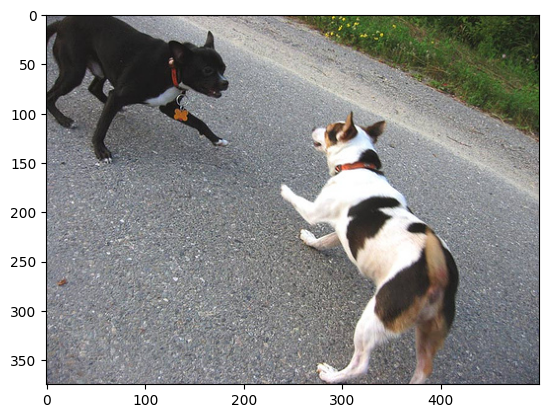

In [ ]:
generate_caption( "1001773457_577c3a7d70.jpg")

-----------------Actual------------------
starseq "a dog shakes its head near the shore red ball next to it ." endseq
starseq white dog shakes on the edge of beach with an orange ball endseq
starseq "dog with orange ball at feet stands on shore shaking off water" endseq
starseq white dog playing with red ball on the shore near the water endseq
starseq white dog with brown ears standing near water with head turned to one side endseq
----------------Predicted------------------
startseq similar brown white dog is running through shallow water endseq


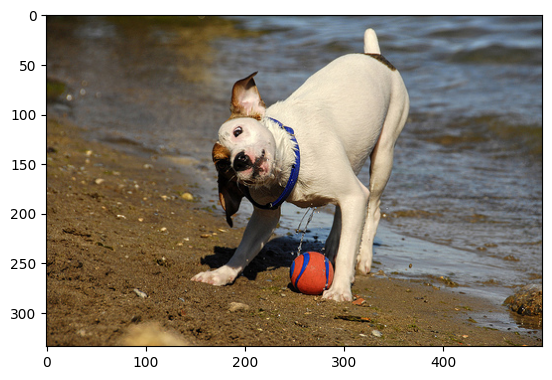

In [ ]:
generate_caption("1012212859_01547e3f17.jpg")

# Generate Poem

In [ ]:
def generate_caption2(image_name):
  #load the image
  #image_name= "1001773457_577c3a7d70.jpg"
  image_id=image_name.split('.')[0]
  img_path=os.path.join(BASE_DIR,'Images',image_name)
  image=Image.open(img_path)
  captions=mapping[image_id]
  #predict the caption
  y_pred=predict_caption(model,features[image_id],tokenizer,max_length)
  return y_pred

In [ ]:
model = keras.models.load_model('img_model.h5')

In [ ]:
caption = generate_caption2( "1001773457_577c3a7d70.jpg")

caption = caption.removep_prefix('startseq')
caption = caption.removep_suffix('endseq')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
from fastai.text.all import GPT2TokenizerFast, load_learner
pretrained_weights = 'gpt2'
tokenizer = GPT2TokenizerFast.from_pretrained(pretrained_weights)
learn = load_learner('PoeticTextGenerator.pkl')

In [ ]:
prompt = caption # initial text prompt to start your generated text
prompt_ids = tokenizer.encode(prompt)
inp = tensor(prompt_ids)[None].cuda()
inp.shape

torch.Size([1, 7])

In [ ]:
preds = learn.model.generate(inp, max_length=100, num_beams=5, no_repeat_ngram_size=2, early_stopping=True, pad_token_id=50256)
print("Output:\n" + 100 * '-')
print(tokenizer.decode(preds[0].cpu().numpy(), skip_special_tokens=True))

Output:
----------------------------------------------------------------------------------------------------
Two dogs are playing with each other,
And one of them is lying on the floor
With a broken arm.
"He's a dog," I say, "but he's got a brain."
He replies: "I don't think so. I mean, look at him!
Look at his eyes! They look like a child's eyes;
They're full of hope! 'Twas the end of the world's desire
For me when I was a boy.
